## 0. Libarary 불러오기 및 경로설정

In [8]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from architecture.model import ResNet18, MyEnsemble, Beit

In [9]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

## 1. Model 정의

In [11]:
# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
device = torch.device('cuda')
model = ResNet18().to(device)
model.load_state_dict(torch.load("./model/resnet_cutmix/best.pth"))
model.eval()

ResNet18(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

## 2. Test Dataset 정의

In [12]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = np.asarray(image)
            image = self.transform(image=image)['image']
            
        return image

    def __len__(self):
        return len(self.img_paths)

## 3. Inference

In [13]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform=A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)),
    ToTensorV2()
])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in tqdm(loader):
    with torch.no_grad():
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

100%|██████████| 12600/12600 [02:24<00:00, 87.23it/s] 

test inference is done!


### 간단히 비율 보기

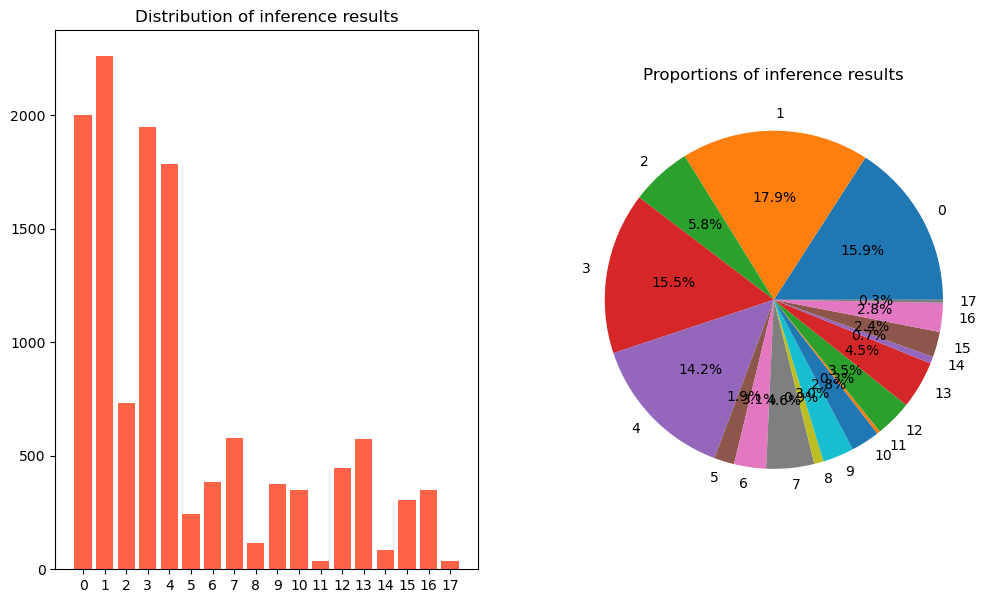

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 7))

classes = [str(x) for x in set(all_predictions)]
cnt_per_class = [0] * len(classes)
for prediction in all_predictions:
    cnt_per_class[prediction] += 1

axes[0].bar(classes, cnt_per_class, color='tomato')
axes[0].set_title('Distribution of inference results')

axes[1].pie(cnt_per_class, labels=[str(x) for x in range(0, 18)], autopct='%.1f%%')
axes[1].set_title('Proportions of inference results')

plt.show()